EDA To Prediction (DieTanic)을 보고 필사했습니다. - https://www.kaggle.com/code/ash316/eda-to-prediction-dietanic/notebook

---

> 삶은 때론 잔인한 유머 감각을 가집니다.
> 
> 삶은 당신이 항상 원했던 것을 가장 최악의 시간에 가지게 합니다.

타이타닉의 침몰은 역사 상 가장 악명 높은 난파 중 하나입니다. 

1912년 4월 15일, 타이타닉의 첫번째 항해에서 타이타닉은 빙산과 부딪친 후 가라 앉았는데, 거기서 총 2224명의 승객과 선원 중 1502명이 사망했습니다. 그래서 "DieTanic"이라고도 불리는 이유가 바로 이 때문입니다. 정말 잊을 수 없는 재난이고, 세계 어느 누구도 잊을 수 없습니다. 

타이타닉을 모두 짓는데 750만 달러 가까이 들었고, 충돌 때문에 바다 아래로 가라앉았습니다. 타이타닉 데이터셋은 데이터 사이언스를 탐험하고 Kaggle 경쟁에 참여를 시작하는 초심자에게 매우 좋은 데이터셋입니다.

이 노트북 목적은 모든 예측 모델링 문제의 workflow가 어떤 것인지 아이디어를 제공하는 것입니다. 어떻게 feature들을 체크하고, 어떻게 새로운 features들과 몇몇 머신 러닝 컨셉을 추가하는지. 나는 어떤 초심자도 모든 맥락을 이해할 수 있도록 노트북을 가능한한 기초적으로 하려고 노력해왔습니다. 

만일 당신이 이 노트북을 좋아하고 당신에게 도움을 줬다고 생각한다면, UPVOTE 해주세요. 
이것은 제게 동기를 일으켜줍니다.

# 목차

**Part1: 데이터 분석 탐험(EDA)**

1. feature들을 분석
2.  여러 feature들을 고려해서 어떤 관계, 트랜드가 있는지 찾음

**Part2: Feature 엔지니어링 & 데이터 클린징**

1. feature를 추가
2. 장황한 feature들은 제거
3. 모델에 적합한 형식으로 feature들을 변환

**Part3: 모델로 예측하기**

1. 기본 알고리즘 돌리기
2. Cross Validation
3. Ensembling
4. 중요한 feature 추출



# Part1: 데이터 분석 탐험(EDA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/colab/data-analysis-practice/data/01_titanic/train.csv')

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# 전체에서 null 값이 있는지 확인

data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Age, Cabin, Embarked**가 null 값입니다. 이를 수정할 예정입니다.

## 얼마나 생존했을까?

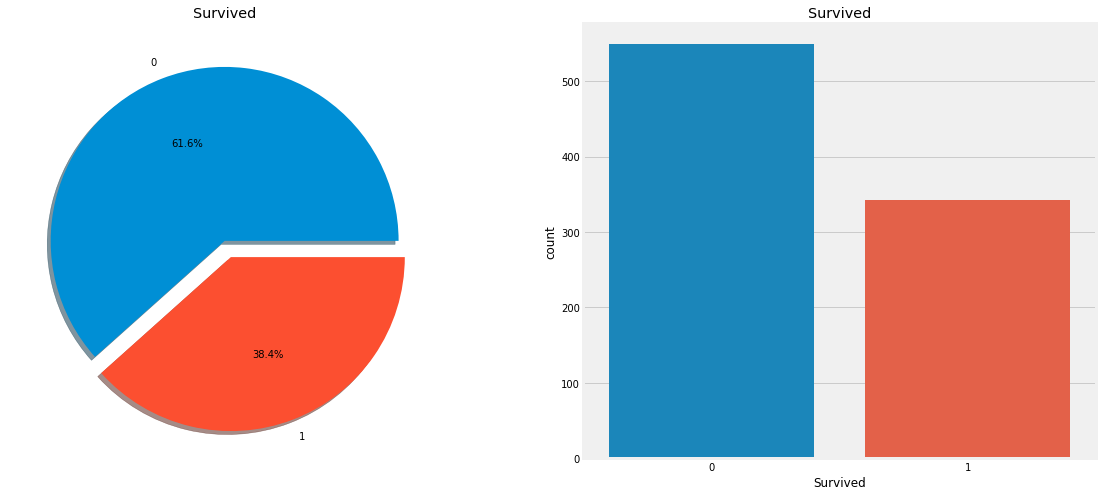

In [6]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

survived = data['Survived'].value_counts()
survived.plot.pie(
    explode=[0, 0.1], 
    autopct='%1.1f%%', 
    ax=ax[0], 
    shadow=True
)

ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=data, ax=ax[1])
ax[1].set_title('Survived')
plt.show()



많은 승객들이 사고에서 생존하지 않았던 사고입니다.

training dataset에서 891명이 넘는 승객들이 생존하지 않았고, 오직 38.4%인 350명만이 생존했습니다. 우리는 더 나은 인사이트를 얻고 동시에 어떤 승객들이 생존했는지 아닌지를 보기 위해 데이터를 더 파볼 필요가 있습니다.

우리는 데이터셋의 각기 다른 feature들을 사용해서 생존율을 확인할 예정입니다. 몇몇 feature들은 성별, 승선항, 나이 등입니다.

먼저 feature들의 type들을 이해해봅시다.

## Features의 Type들

**Categorical Features (범주형 features)**
- 범주형 값은 두개 이상의 범주가 있고 해당 feature의 각 값을 범주별로 분류할 수 있는 값입니다.
- 예를 들어, 성별은 (남/여) 두 범주를 가지는 범주형 값입니다.
- 정렬할 수 없거나 각 값에 어떤 순서도 없습니다.
- "Nominal Variables(명목변수)"라고 부르기도 합니다.
- 데이터셋에서 범주형 feature들 : Sex, Embarked

**Ordinal Features (순서형 features)**
- 순서형 값은 범주형 값과 비슷하지만, 차이점은 값 간의 상대적인 순서 또는 정렬을 가질 수 있다는 것입니다.
- 만일 "Tall, Medium, Short"값을 가지는 Height(높이) feature를 가진다면, Height는 순서형 값입니다. 여기서 값에 상대적인 정렬을 가질 수도 있습니다.
- 데이터셋에서 순서형 feature들 : PClass

**Continous Features (연속형 features)**
- 어떤 두 포인트 사이에 값들을 가지거나 최소/최대 값들 사이에 값들을 가질 수 있다면 연속형 features라고 말합니다.
- 데이터셋에서 연속형 feature들 : Age

## Feature들 분석

### Sex -> 범주형 feature

In [10]:
data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

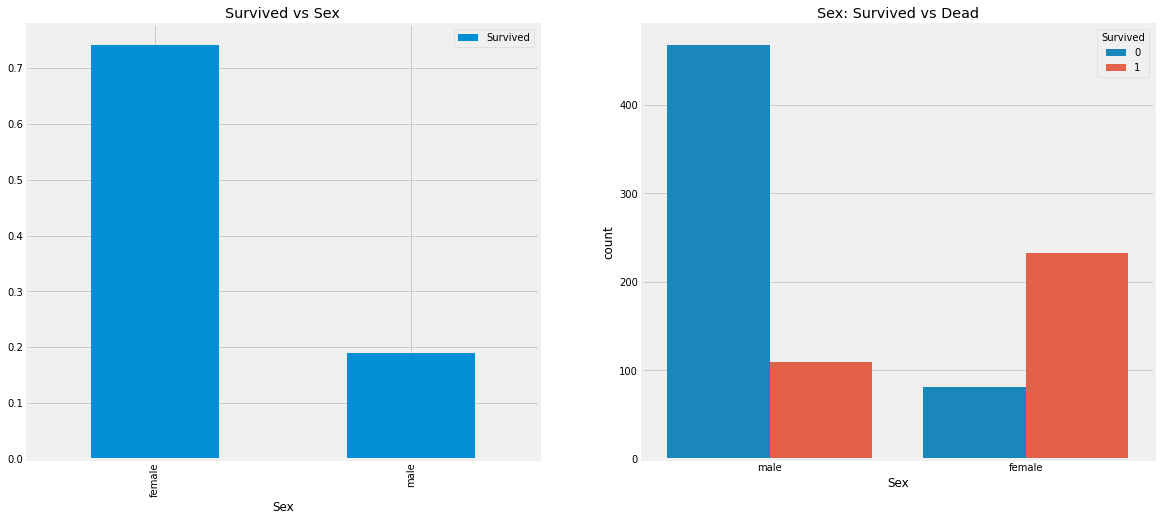

In [12]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')

sns.countplot('Sex', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')

plt.show()

이부분이 흥미롭네요.

배에 탑승한 남성의 수가 여성의 수보다 더 많습니다. 여전히 구해진 여성의 수가 거의 남성의 수보다 두배이구요. 이 배에서 여성의 생존율은 (남성이 18-19%인데 반해) 약 75%입니다. 

이건 모델링에서 매우 중요한 feature로 보입니다. 그러나 이것뿐이면 될까요? 다른 feature들도 살펴보겠습니다.

### Pclass -> 순서형 feature

In [14]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


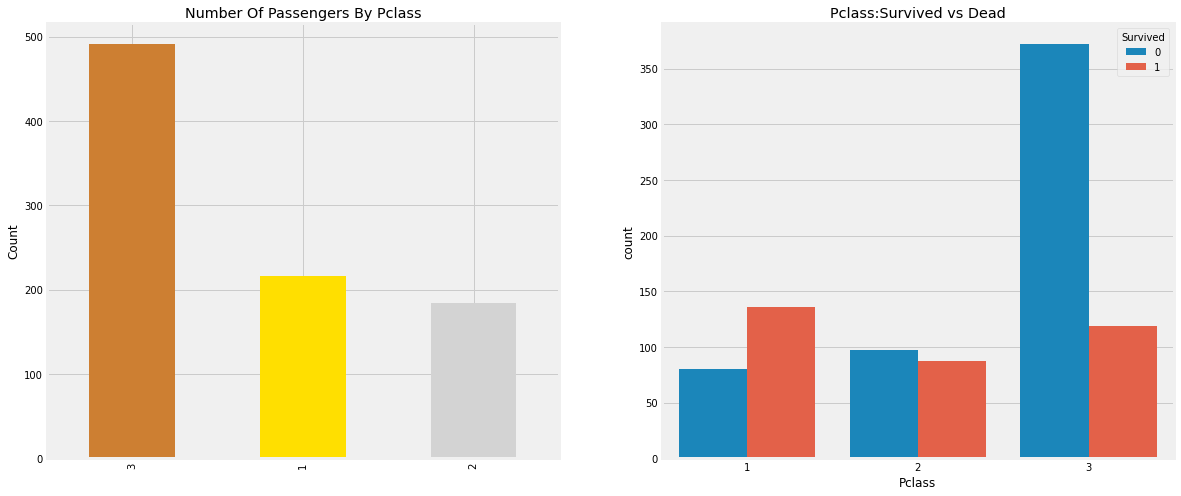

In [15]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')

sns.countplot('Pclass', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')

plt.show()

사람들은 돈으로 모든걸 살 순 없다고 말합니다. 그러나 우리는 Pclass 1 승객들이 구조에 매우 높은 우선순위를 가지고 있음을 명백하게 볼 수 있습니다. 심지어 Pclass 3의 승객들의 수가 더 많음에도 불구하고, Pclass 3에서 생존자 수는 약 25%를 맴돌고 있습니다.

Pclass 1의 생존율은 약 63%, Pclass 2는 약 48%입니다. 그래서 돈과 지위는 상관이 있습니다. 물질만능주의 세상이네요.

조금 더 파고들어서 다른 흥미로운 관찰들을 해봅시다. Sex와 Pclass를 가지고 함께 생존율을 확인해봐요.

In [16]:
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient(cmap='summer_r')

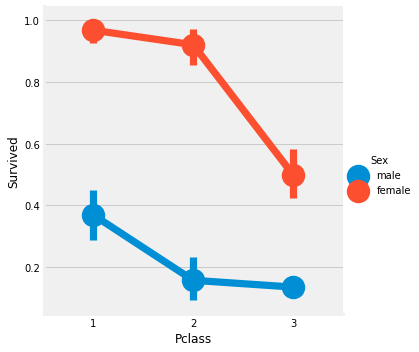

In [17]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=data)
plt.show()

범주형 값을 쉽게 분리할 수 있기 때문에 우리는 이 케이스에서 FactorPlot을 사용합니다.

CrossTab과 FactorPlot을 보면 Pclass 1 여성에 대한 생존율이 약 95-96%라고 쉽게 추론할 수 있습니다.